In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Set NPM untuk seed random
NPM = 2408
np.random.seed(NPM)

# Baca dataset
makan = pd.read_csv("makanan.csv")

# Budget awal
budget_awal = 1e6  # rupiah

# Parameter bobot dasar
wkenyang_base = 0.8
wrasa_base = 0.7
wsehat_base = 0.9  # simpangan lebih besar
wbosan_base = 0.2

# Jumlah simulasi
SAMPLE_NUM = 500

Kode tersebut diawali dengan menetapkan NPM sebagai seed random agar hasil acak yang diperoleh selalu konsisten setiap kali dijalankan. Setelah itu, program membaca dataset makanan dari file makanan.csv yang berisi informasi mengenai daftar menu dan atribut terkait. Budget awal ditetapkan sebesar satu juta rupiah untuk digunakan dalam simulasi. Selanjutnya, ditentukan pula bobot dasar untuk beberapa faktor penilaian makanan, yaitu kenyang, rasa, sehat, dan bosan, dengan nilai tertentu yang menunjukkan tingkat kepentingannya dalam perhitungan. Terakhir, jumlah simulasi ditetapkan sebanyak 500 kali untuk mendapatkan variasi pola makan yang dapat dianalisis lebih lanjut.

In [ ]:
# Array untuk menyimpan hasil
sampleid= np.arange(0, 500)
# skor perorangan
skor = np.zeros(SAMPLE_NUM, dtype=np.double)
sisa = np.zeros(SAMPLE_NUM, dtype=np.double)
sehat = np.zeros(SAMPLE_NUM, dtype=np.double)
pilihanku = np.zeros(SAMPLE_NUM, dtype=np.double)

# Batas sisa uang
SISA_MININUM = 150e3
SISA_MAKSIMUM = 300e3
bin_sisa = np.arange(SISA_MININUM, SISA_MAKSIMUM, 1000)

# Respon simulasi
resp_sehat = np.zeros((SAMPLE_NUM, len(bin_sisa)), dtype=np.double)
resp_pilih = np.zeros((SAMPLE_NUM, 62), dtype=np.double)

kode ini digunakan untuk menyiapkan wadah data yang akan diisi selama proses simulasi berlangsung. Variabel sampleid berisi nomor indeks dari 0 hingga 499 sebagai identitas masing-masing percobaan. Empat array skor, sisa, sehat, dan pilihanku disiapkan dengan ukuran sesuai jumlah simulasi untuk menyimpan skor kumulatif, sisa uang, nilai kesehatan, dan pilihan menu yang dihasilkan tiap sampel. Kemudian ditetapkan rentang batas minimal dan maksimal sisa uang yang diharapkan, yaitu antara seratus lima puluh ribu hingga tiga ratus ribu rupiah, serta bin_sisa digunakan untuk membuat interval analisis setiap seribu rupiah. Dua array besar lainnya, resp_sehat dan resp_pilih, dibuat untuk menyimpan respons kesehatan terhadap variasi sisa uang serta catatan pilihan makanan yang diambil pada setiap simulasi selama tiga puluh satu hari dengan dua kali makan per hari.


In [ ]:
for n in range(SAMPLE_NUM):
    budget = budget_awal
    skor_kumulatif = 0
    skor_sehat = 0

    for i in range(31):  # 31 hari
        # makan pertama, pilih secara acak
        pilihan = np.random.randint(0, len(makan))
        w_kenyang = np.random.normal(loc=wkenyang_base, scale=0.3)
        w_rasa = np.random.normal(loc=wrasa_base, scale=0.2)
        w_sehat = np.random.normal(loc=wsehat_base, scale=0.3)
        w_bosan = np.random.normal(loc=wbosan_base, scale=0.2)

        if i > 0 and resp_pilih[n][2*i - 2] == pilihan:
            w_bosan *= 2

        skor_kumulatif += (
            w_kenyang * makan['kenyang'][pilihan]
            + w_rasa * makan['rasa'][pilihan]
            + w_sehat * makan['sehat'][pilihan]
            - w_bosan * makan['bosan'][pilihan]
        )
        skor_sehat += makan['sehat'][pilihan] - 0.5
        budget -= makan['harga'][pilihan]
        resp_pilih[n][2*i]= pilihan

        # makan kedua
        pilihan = np.random.randint(0, len(makan))
        w_kenyang = np.random.normal(loc=wkenyang_base, scale=0.3)
        w_rasa = np.random.normal(loc=wrasa_base, scale=0.3)
        w_sehat = np.random.normal(loc=wsehat_base+0.2, scale=0.2)
        w_bosan = np.random.normal(loc=wbosan_base*2, scale=0.2)

        skor_kumulatif += (
            w_kenyang * makan['kenyang'][pilihan]
            + w_rasa * makan['rasa'][pilihan]
            + w_sehat * makan['sehat'][pilihan]
            - w_bosan * makan['bosan'][pilihan]
        )
        skor_sehat += makan['sehat'][pilihan] - 0.5
        budget -= makan['harga'][pilihan]
        resp_pilih[n][2*i+1] = pilihan

    # Simpan hasil
    sisa[n] = budget
    skor[n] = skor_kumulatif
    sehat[n] = skor_sehat
    resp_sehat[n][int((budget-SISA_MININUM)/1000)] = skor_sehat

kode ini adalah inti dari simulasi, di mana setiap iterasi mewakili satu percobaan dengan budget awal satu juta rupiah yang dijalankan selama 31 hari. Setiap harinya dilakukan dua kali pemilihan makanan secara acak, dan nilai bobot seperti kenyang, rasa, sehat, serta bosan ditentukan menggunakan distribusi normal agar hasil lebih realistis dan bervariasi. Jika menu makan pertama hari ini sama dengan menu sebelumnya, bobot bosan akan diperbesar sehingga skor kepuasan berkurang. Skor kumulatif ditambahkan berdasarkan bobot dan atribut makanan, skor kesehatan diakumulasi, serta budget dikurangi dengan harga makanan yang dipilih. Data menu yang dipilih juga dicatat dalam array resp_pilih untuk dianalisis kembali.

Setelah 31 hari, hasil simulasi disimpan dalam beberapa array: sisa budget dalam sisa, skor total kepuasan dalam skor, skor kesehatan dalam sehat, dan distribusi skor kesehatan terhadap sisa uang dalam resp_sehat. Dengan demikian, blok kode ini memungkinkan untuk mengevaluasi hubungan antara pilihan makanan, tingkat kepuasan, kesehatan, dan pengeluaran selama periode simulasi penuh.

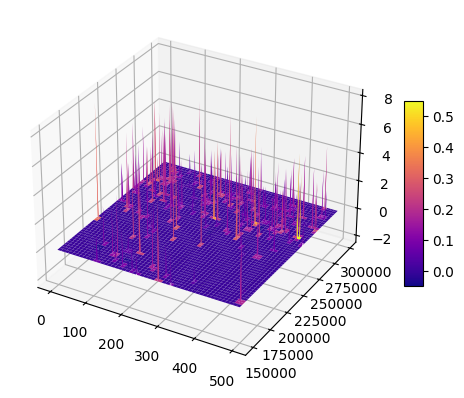

In [ ]:
# Visualisasi 3D
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
Y, X = np.meshgrid(bin_sisa, sampleid)
# Colorize the surface using a colormap
surf = ax.plot_surface(X, Y, resp_sehat,
                       cmap='plasma',   # try 'plasma', 'coolwarm', etc.
                       edgecolor='none')
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)

Pada grafik ini sumbu X menunjukkan jumlah sisa uang, sumbu Y menggambarkan indeks pilihan makanan, sedangkan sumbu Z merepresentasikan nilai respon kesehatan sehingga hubungan ketiganya dapat terlihat secara lebih jelas.Terlihat bagaimana variasi sisa uang dan pilihan makanan berpengaruh terhadap respon kesehatan yang ditampilkan pada sumbu Z. Daerah dengan warna lebih terang menunjukkan nilai kesehatan yang relatif lebih tinggi, sedangkan warna gelap menandakan nilai yang rendah. Pola distribusi nilai kesehatan tampak tidak merata, ada titik-titik puncak yang menonjol yang berarti kombinasi tertentu antara sisa uang dan jenis makanan menghasilkan dampak kesehatan yang lebih besar. Colormap memberikan gambaran intensitas sehingga kita bisa melihat perbedaan tingkat kesehatan dengan lebih mudah, bahkan pada area yang rapat dengan data. Dengan demikian, grafik ini membantu memahami interaksi antara anggaran makanan, variasi pilihan, dan hasil kesehatan yang diperoleh.


In [ ]:
# TUGAS
# (1) cari pola makan mana saja yang menghasilkan nilai kumulatif kesehatan (resp_sehat) positif
# (2) cari titik-titik dengan sisa uang bulanan positif dari (1)
# (3) cari titik dengan skor skumulatif terbesar (skor) di mana nilai kumulatif kesehatannya positif
# (4) tampikan jadwal makanan sesuai pilihan (resp_pilih)

In [ ]:
# 1. Mencari pola makan mana saja yang menghasilkan nilai kumulatif kesehatan (resp_sehat) positif

indeks_sehat = [i for i in range(len(sehat)) if sehat[i] > 0]

print(f"Jumlah pola sehat: {len(indeks_sehat)} dari {len(sehat)}\n")

for idx in indeks_sehat[:3]:  # tampilkan contoh 3
    print(f"Pola {idx} (Skor Sehat = {sehat[idx]:.2f})")

Jumlah pola sehat: 472 dari 500

Pola 0 (Skor Sehat = 4.70)
Pola 1 (Skor Sehat = 0.80)
Pola 2 (Skor Sehat = 3.70)


Dari hasil simulasi, sebanyak 472 dari 500 pola makan menunjukkan nilai kesehatan yang positif. Artinya, sebagian besar pilihan makanan selama sebulan cenderung menyehatkan karena kandungan gizinya cukup baik dan pemilihannya bervariasi. Meski begitu, hasil ini hanya menunjukkan sisi kesehatan saja, sehingga belum tentu semua pola tersebut seimbang dari segi rasa maupun pengeluaran.


In [ ]:
# 2. cari titik-titik dengan sisa uang bulanan positif dari (1)
indeks_sehat_sisa = [i for i in range(len(sehat)) if sehat[i] > 0 and sisa[i] > 0]

print(f"Jumlah pola sehat dengan sisa uang positif: {len(indeks_sehat_sisa)} dari {len(sehat)}\n")

# Tampilkan contoh 3 pola
for idx in indeks_sehat_sisa[:3]:
    print(f"Pola {idx} (Skor Sehat = {sehat[idx]:.2f}, Sisa uang = {sisa[idx]:.0f})")

Jumlah pola sehat dengan sisa uang positif: 472 dari 500

Pola 0 (Skor Sehat = 4.70, Sisa uang = 104000)
Pola 1 (Skor Sehat = 0.80, Sisa uang = 109000)
Pola 2 (Skor Sehat = 3.70, Sisa uang = 74000)


Dari hasil simulasi, terdapat 472 dari 500 pola makan yang tidak hanya memiliki nilai kesehatan positif, tetapi juga menyisakan uang di akhir bulan. Hal ini menunjukkan bahwa mayoritas pola tersebut mampu memberikan manfaat kesehatan tanpa melebihi batas anggaran yang telah ditetapkan. Dengan kata lain, pilihan makanan yang diambil cukup seimbang antara nilai gizi dan biaya, sehingga tetap menyehatkan sekaligus ekonomis.


In [ ]:
# 3. cari titik dengan skor skumulatif terbesar (skor) di mana nilai kumulatif kesehatannya positif

indeks_sehat = [i for i in range(len(sehat)) if sehat[i] > 0]

# cari indeks dengan skor maksimum di subset sehat
if indeks_sehat:  # cek kalau ada pola sehat
    idx_max = max(indeks_sehat, key=lambda i: skor[i])
    print("Pola dengan skor kumulatif terbesar (dan sehat):")
    print(f"Pola {idx_max}")
    print(f"  Skor kumulatif = {skor[idx_max]:.2f}")
    print(f"  Skor sehat     = {sehat[idx_max]:.2f}")
    print(f"  Sisa uang      = {sisa[idx_max]:.0f}")
else:
    print("Tidak ada pola dengan kesehatan positif.")


Pola dengan skor kumulatif terbesar (dan sehat):
Pola 261
  Skor kumulatif = 105.62
  Skor sehat     = 5.90
  Sisa uang      = 58000


Dari hasil simulasi, pola makan dengan skor kumulatif terbesar terdapat pada simulasi ke-261 dengan skor total 105,62, skor kesehatan 5,90, dan sisa uang sebesar 58.000. Hasil ini menunjukkan bahwa pola tersebut merupakan kombinasi pilihan makanan yang paling optimal secara keseluruhan, karena tidak hanya memberikan nilai kesehatan positif tetapi juga menghasilkan skor total tertinggi. Artinya, pola ini mampu menyeimbangkan antara aspek kesehatan, kepuasan, dan pengeluaran selama satu bulan.


In [ ]:
# 4. tampikan jadwal makanan sesuai pilihan (resp_pilih)

jadwal = resp_pilih[idx_max]

print("\nJadwal makan terbaik:")
for i in range(0, len(jadwal), 2):
    pagi = int(jadwal[i])
    if pagi >= 0:
        print(f"Hari {i//2 + 1} pagi: {makan['makanan'][pagi]}")
    if i+1 < len(jadwal):
        malam = int(jadwal[i+1])
        if malam >= 0:
            print(f"Hari {i//2 + 1} malam: {makan['makanan'][malam]}")


Jadwal makan terbaik:
Hari 1 pagi: nasipadang
Hari 1 malam: soto
Hari 2 pagi: pempek
Hari 2 malam: soto
Hari 3 pagi: seblak
Hari 3 malam: soto
Hari 4 pagi: mi instan
Hari 4 malam: lontong sayur
Hari 5 pagi: seblak
Hari 5 malam: sate
Hari 6 pagi: roti
Hari 6 malam: rawon
Hari 7 pagi: rawon
Hari 7 malam: cireng
Hari 8 pagi: ikan bakar
Hari 8 malam: sop ayam
Hari 9 pagi: warteg
Hari 9 malam: lontong sayur
Hari 10 pagi: ayam bakar
Hari 10 malam: es buah
Hari 11 pagi: capcay
Hari 11 malam: soto
Hari 12 pagi: mi instan
Hari 12 malam: ikan bakar
Hari 13 pagi: sop ayam
Hari 13 malam: sop ayam
Hari 14 pagi: martabak
Hari 14 malam: soto
Hari 15 pagi: lontong sayur
Hari 15 malam: ayamgeprek
Hari 16 pagi: sate
Hari 16 malam: rawon
Hari 17 pagi: es buah
Hari 17 malam: mieayam
Hari 18 pagi: cireng
Hari 18 malam: gado-gado
Hari 19 pagi: mi instan
Hari 19 malam: sate
Hari 20 pagi: ayamgeprek
Hari 20 malam: ikan bakar
Hari 21 pagi: seblak
Hari 21 malam: sate
Hari 22 pagi: pempek
Hari 22 malam: capcay


Berdasarkan hasil simulasi, jadwal makan terbaik diperoleh dari pola dengan skor kumulatif tertinggi sekaligus tetap menjaga nilai kesehatan yang positif. Jadwal tersebut menampilkan kombinasi menu yang cukup beragam, mulai dari makanan berat seperti nasi padang, rawon, sop ayam, sate, dan ayam bakar, hingga makanan ringan atau selingan seperti es buah, gorengan, martabak, dan cireng. Variasi pilihan ini membuat pola konsumsi tidak monoton serta membantu menjaga keseimbangan antara kebutuhan gizi, rasa, dan anggaran yang tersedia.

Dengan adanya campuran makanan sehat, mengenyangkan, serta beberapa menu ringan sebagai variasi, pola ini dianggap optimal karena mampu memberikan keseimbangan antara kesehatan tubuh, kenikmatan dalam makan, dan keberagaman menu selama 31 hari. Selain itu, tetap terjaganya sisa anggaran memperlihatkan bahwa simulasi berhasil menghasilkan jadwal makan yang efisien sekaligus realistis untuk dijalankan.

Prompt chatgpt yang digunakan: "Tolong buatkan aku langkah membuat kode Python untuk simulasi pola makan selama 30 hari dengan budget 1 juta rupiah dan setiap hari ada 2 kali makan yang dipilih secara acak."
Jawaban:
1. Siapkan data makanan.
2. Set budget = 1 juta.
3. Membuat loop simulasi makan (Setiap hari → 2 kali makan → pilih makanan acak dengan np.random.randint.)
4. Kurangi budget sesuai harga.
5. Simpan jadwal dan tampilkan.